# NLP kullanarak anahtar Kelime Çıkarımı

Bu projede belirli bir alan ile ilgili pdf dosyaları ve youtube video altyazılarından text verileri çekilerek bu alana özgü anahtar kelimeler ve beraber sık bulunan ikili üçlü kelimeler bulunmaya çalışılmıştır. 

özellikle https://github.com/andybywire/nlp-text-analysis yararlanılmıştır.

Google Collabs için kurulması gereken paketler

In [1]:
# !pip install youtube_transcript_api
# !pip install google-cloud-translate
# !pip install PyPDF2
# !pip install spacy
# !pip install nltk
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Gerekli kütüphaneler içeri aktarılır

- youtube_transcript_api -> youtube videolarının altyazılarını indirmeyi sağlar.
- google.cloud translate -> dil çevirisi yapmak için
- PyPDF2 -> Pdf dosyalarından text çıkarımı için

In [2]:
import os
from os import path
import re
from genericpath import isfile

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# imports and load spacy english language package
import spacy
from spacy import displacy
from spacy import tokenizer
nlp = spacy.load('en_core_web_sm')

import pandas as pd
from youtube_transcript_api import YouTubeTranscriptApi
import PyPDF2 as pydf
from google.cloud import translate_v2 as translate

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\somebody\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\somebody\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\somebody\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
print(len(stop_words))

179


In [4]:
usr = os.getlogin()
os.chdir('/Users/'+usr+'/github/notebooks/nlp_proje')
mypath = os.getcwd()

#### Custom Stopwords
Kendi istediğimiz kelimeleri ekliyebileceğimiz costom stopwords dosyasını ekleyip mevcut stopwords ile birleştiriyoruz.

In [5]:
# Load a set of custom stop words from a text file (one stopword per line)
csw = set(line.strip() for line in open(mypath + '/custom-stopwords.txt'))
csw = [sw.lower() for sw in csw]

In [6]:
print(csw)

['youknow', 'non', 'delirium', 'okey', 'am', 'alot', 'uh', 'umso', 'gonna', 'much', 'whatwe', 'sorry', 'same', 'she', 'is', 'he', 'yes', 'are', 'you', 'hi', 'um', 'yeah', 'no', 'it', 'goingto', 'word', 'how', 'umand']


In [7]:
# Combine custom stop words with stop_words list
stop_words = stop_words.union(csw)

In [8]:
print(len(stop_words))

197


#### Temizleme Fonksiyonu:
- Noktalama işaretlerini çıkar
- Küçük harfe dönüştür
- Etiketleri kaldır
- Özel karakter ve rakamları temizle
- Lemmatizasyon gerçekleştir

In [9]:
def clean(input_text, _stop_words):
    # Remove punctuation
    text = re.sub('[^a-zA-Z]', ' ', input_text)

    # Convert to lowercase
    text = text.lower()

    # Remove tags
    text=re.sub('&lt;/?.*?&gt;',' &lt;&gt; ',text)

    # Remove special characters and digits
    text=re.sub('(\\d|\\W)+',' ',text)

    # Convert to list from string
    text = text.split()

    # Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if ((not word in  
            _stop_words) and (len(word)<16 and len(word)>3))] 
    text = ' '.join(text)
    return text

## PDF DOSYALARINI ÇEVİR

#### İstediğimiz alan dışındaki örnek pdf dosyalar için:

    - Alandışı kelimeleri elemek için alan dışı pdf'lerin kelimeleri çıkarılır 
    - Bulunan kelimeler stopwords listesi ile birleştirilir.

In [10]:
stopwords_pdf_files = [f for f in os.listdir(mypath+'/stopwords_pdf')]

In [11]:
print('PDF files currently on your folder: ')
print(stopwords_pdf_files,'\n')

PDF files currently on your folder: 
['1-NLP-Practioner-interventions-1-50-English.pdf', 'Applying UML and Patterns 3rd Edition.pdf', 'emma.pdf', "Gödel's incompleteness theorems - Wikipedia.pdf", 'Karaboga ve Basturk - 2007 - A powerful and efficient algorithm for numerical f.pdf', 'les-miserables.pdf', 'numerical_methods_for_engineers_for_engineers_chapra_canale_6th_edition.pdf', 'Object-oriented-analysis-and-design-with-applications-2nd-edition.pdf', 'Operating_Systems_Internals_and_Design_Principles_7th_Edition_William_Stallings.pdf', 'pride-and-prejudice.pdf', 'the-adventures-of-huckleberry-finn.pdf', 'the-hound-of-the-baskervilles.pdf', 'the-three-musketeers.pdf', 'war-and-peace.pdf', 'WHAT IS NLP word.pdf'] 



In [12]:
stopwords_book_text = ""
print("=============START=============")
for spf in stopwords_pdf_files:
    if '.pdf' in spf:
        print('===>'+ spf)
        reader = pydf.PdfFileReader(mypath+'/stopwords_pdf/'+ spf, strict=False)
        number_of_pages = reader.numPages
        for page in reader.pages:
            stopwords_book_text += page.extractText()
print("==============END==============")    

=============START=============
===>1-NLP-Practioner-interventions-1-50-English.pdf
===>Applying UML and Patterns 3rd Edition.pdf
===>emma.pdf
===>Gödel's incompleteness theorems - Wikipedia.pdf
===>Karaboga ve Basturk - 2007 - A powerful and efficient algorithm for numerical f.pdf
===>les-miserables.pdf
===>numerical_methods_for_engineers_for_engineers_chapra_canale_6th_edition.pdf
===>Object-oriented-analysis-and-design-with-applications-2nd-edition.pdf
===>Operating_Systems_Internals_and_Design_Principles_7th_Edition_William_Stallings.pdf
===>pride-and-prejudice.pdf
===>the-adventures-of-huckleberry-finn.pdf
===>the-hound-of-the-baskervilles.pdf
===>the-three-musketeers.pdf
===>war-and-peace.pdf
===>WHAT IS NLP word.pdf
==============END==============


In [13]:
stopwords_pdf_word_text = word_tokenize(stopwords_book_text)

In [14]:
print(len(stopwords_pdf_word_text),' words')

6848693  words


In [16]:
stopwords_pdf_words = []
for i in stopwords_pdf_word_text:
    x = clean(i, set()) #burada temizlik işleminde stopwords kullanmıyoruz
    if(x!=''):
        stopwords_pdf_words.append(x)
stopwords_pdf_words_set = set(word for word in stopwords_pdf_words)

In [17]:
# print(pdf_words)
print(len(stopwords_pdf_words),' words')
print(len(stopwords_pdf_words_set),' words')

732544  words
54917  words


In [18]:
stop_words = stop_words.union(stopwords_pdf_words_set)

In [19]:
print(len(stop_words))

55035


In [20]:
# youtube altyazılarını getir
yst = [line.strip().split("=")[1].split("&")[0] for line in open(mypath + '/stopwords_youtube_links.txt') if line.strip() !='']
print(len(yst))

54


In [21]:
stopwords_subtitles = ""

for st in yst:
  sub = YouTubeTranscriptApi.get_transcript(st)
  text = ""  
  for i in sub:
      text += i["text"]
  stopwords_subtitles += text

subtitle_corpus = clean(stopwords_subtitles, set())

In [22]:
stopwords_y_words = word_tokenize(subtitle_corpus)
stopwords_y_words_set = set(word for word in stopwords_y_words)

In [23]:
print(len(stopwords_y_words))
print(len(stopwords_y_words_set))

121499
17143


In [24]:
stop_words = stop_words.union(stopwords_y_words_set)
print(len(stop_words))

67553


In [25]:
with open(mypath+"\pdf_stopwords.csv", "w") as file:
  for word in stop_words:
    file.write(word+",")

# İstediğimiz alandaki pdf dosyalar için:

In [26]:
pdf_files = [f for f in os.listdir(mypath+'/pdf')]

In [27]:
print('PDF files currently on your folder: ')
print(pdf_files,'\n')

PDF files currently on your folder: 
['1-s2.0-S1076633221004189.pdf', '2021.teachingnlp-1.21.pdf', 'glaa275.pdf', 'introduction-to-natural-language-processing.pdf', "Natural Language Processing with Python - O'Reilly2009.pdf", 'Natural_Language_Processing_Succinctly.pdf', 'nlp-book.pdf', 'nlpwp.pdf', 'ocab228.pdf', 'revised.pdf'] 



In [28]:
book_text = ""
print("=============START=============")
for pf in pdf_files:
    if '.pdf' in pf:
        print('===>'+ pf)
        reader = pydf.PdfFileReader(mypath+'/pdf/'+ pf, strict=False)
        number_of_pages = reader.numPages
        for page in reader.pages:
            book_text += page.extractText()
print("==============END==============")    

=============START=============
===>1-s2.0-S1076633221004189.pdf
===>2021.teachingnlp-1.21.pdf
===>glaa275.pdf
===>introduction-to-natural-language-processing.pdf
===>Natural Language Processing with Python - O'Reilly2009.pdf
===>Natural_Language_Processing_Succinctly.pdf
===>nlp-book.pdf
===>nlpwp.pdf
===>ocab228.pdf
===>revised.pdf
==============END==============


In [29]:
book_corpus = clean(book_text, stop_words)

In [30]:
print(len(book_corpus))

283440


In [31]:
pdf_sentence_text = sent_tokenize(book_text)

In [32]:
# print(pdf_sentence_text)
print(len(pdf_sentence_text), ' sentences')

18930  sentences


In [33]:
pdf_sentences = []
for i in pdf_sentence_text:
    x = clean(i, set()) #burada temizlik işleminde stopwords kullanmıyoruz
    if(x!=''):
        pdf_sentences.append(x)

In [34]:
# print(pdf_sentences)
print(len(pdf_sentences), ' sentences')

7663  sentences


In [35]:
pdf_word_text = word_tokenize(book_text)

In [36]:
# print(pdf_word_text[100:])
print(len(pdf_word_text),' words')

299615  words


In [37]:
pdf_words = []
for i in pdf_word_text:
    x = clean(i, stop_words)
    if(x!=''):
        pdf_words.append(x)
pdf_words_set = set(word for word in pdf_words)

In [38]:
# print(pdf_words)
print(len(pdf_words),' words')
print(len(pdf_words_set),' words')

32245  words
13948  words


In [39]:
print(len(pdf_words_set))

13948


## YOUTUBE ALT YAZILARINI İŞLE

In [40]:
# youtube altyazılarını getir
yst = [line.strip().split("=")[1].split("&")[0] for line in open(mypath + '/youtube_links.txt') if line.strip() !='']
print(len(yst))

23


In [41]:
subtitles = ""

for st in yst:
  sub = YouTubeTranscriptApi.get_transcript(st)
  text = ""  
  for i in sub:
      text += i["text"]
  subtitles += text

subtitle_corpus = clean(subtitles, stop_words)

In [42]:
y_words = word_tokenize(subtitle_corpus)
y_words_set = set(word for word in y_words)

In [43]:
print(len(y_words))
print(len(y_words_set))

36345
21628


In [44]:
with open(mypath+"\subtitle.csv", "w") as file:
  for word in y_words_set:
    file.write(word+",")

#### ELDE EDİLEN KELİMELERİ BİRLEŞTİRME

In [45]:
all_words_set = pdf_words_set.union(y_words_set)

In [46]:
print(len(all_words_set))

34499


In [47]:
with open(mypath+"\words.csv", "w") as file:
  for word in all_words_set:
    file.write(word+",")

In [48]:
all_words = y_words + pdf_words

In [49]:
corpus = book_corpus + subtitle_corpus

In [50]:
#ardarda tekrar eden kelimeleri engelle
temp_list = corpus.split()
corpus_t = ''
for i in range(1,len(temp_list)):
    if temp_list[i]!= temp_list[i-1]:
        corpus_t += temp_list[i]+' '
corpus = [corpus_t]

In [51]:
# View 10 most common words prior to text pre-processing
freq = pd.Series(' '.join(map(str, corpus)).split()).value_counts()[:20]
freq

word        982
nltk        580
corpus      556
model       461
thing       405
sentence    253
system      195
language    184
rule        181
example     176
question    173
token       165
feature     163
mean        154
vector      147
student     143
grammar     141
term        136
work        128
task        125
dtype: int64

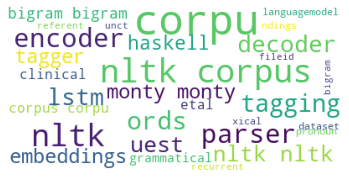

In [52]:
# Generate word cloud

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=30,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(all_words).replace('\'',' '))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig(mypath + "\wordcloud.png", dpi=900)

In [53]:
# Tokenize the text and build a vocabulary of known words

cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(all_words)

In [54]:
# Sample the returned vector encoding the length of the entire vocabulary
list(cv.vocabulary_.keys())[:10]

['spacey',
 'mattingly',
 'multilingual',
 'medieval',
 'regex',
 'parser',
 'recognizer',
 'oftentimes',
 'tagging',
 'summarization']

     Keyword  Frequency
0       word        982
1       nltk        580
2     corpus        556
3      model        461
4      thing        405
5   sentence        253
6     system        195
7   language        184
8       rule        181
9    example        176
10  question        173
11     token        165
12   feature        163
13      mean        154
14    vector        147
15   student        143
16   grammar        141
17      term        136
18      work        128
19      task        125
20       way        124
21      sent        122
22    result        116
23      idea        116
24    parser        113


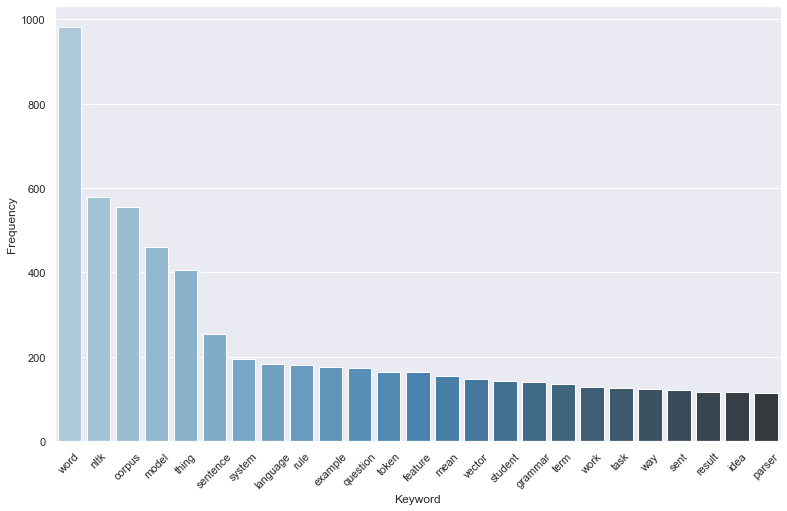

In [55]:
# View most frequently occuring keywords
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

# Convert most freq words to dataframe for plotting bar plot, save as CSV
top_words = get_top_n_words(corpus, n=25)
top_df = pd.DataFrame(top_words)
top_df.columns=["Keyword", "Frequency"]
print(top_df)
top_df.to_csv(mypath + '\_top_words.csv')

# Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Keyword", y="Frequency", data=top_df, palette="Blues_d")
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.figure.savefig(mypath + "\_keyword.png", bbox_inches = "tight")

                 Bi-gram  Frequency
0            nltk corpus        155
1         colorless idea         54
2         idea furiously         52
3            corpus word         50
4          word category         32
5          nltk freqdist         30
6              word nltk         29
7       lexical resource         28
8          nltk tokenize         27
9            corpus nltk         26
10          tagging word         26
11       nltk featstruct         26
12              uest ion         26
13        katherine liao         26
14        corpus lexical         23
15         sent category         22
16  rheumatoid arthritis         22
17      nltk defaultdict         18


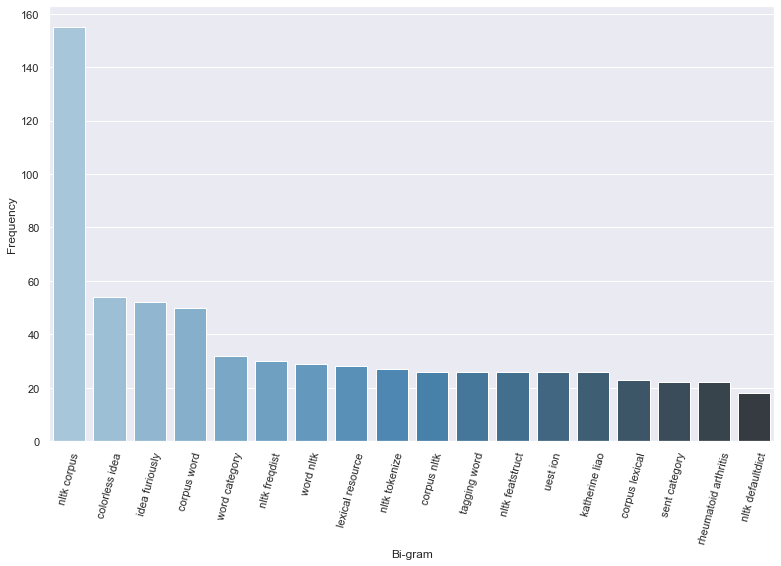

In [56]:
# Most frequently occuring bigrams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

# Convert most freq bigrams to dataframe for plotting bar plot, save as CSV
top2_words = get_top_n2_words(corpus, n=18)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Frequency"]
print(top2_df)
top2_df.to_csv(mypath + '\_bigrams.csv')

# Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Frequency", data=top2_df, palette="Blues_d")
h.set_xticklabels(h.get_xticklabels(), rotation=75)
h.figure.savefig(mypath + "\_bi-gram.png", bbox_inches = "tight")

                          Tri-gram  Frequency
0         colorless idea furiously         46
1                 nltk corpus word         33
2          corpus lexical resource         23
3                 word nltk corpus         19
4   canakkale onsekiz universitesi         17
5       featstruct nltk featstruct         17
6         idea furiously colorless         16
7             nltk featstruct nltk         16
8               corpus nltk corpus         14
9            nltk corpus gutenberg         14
10            nltk corpus treebank         14
11        furiously colorless idea         14
12  openfile readmode hgetcontents         14
13            http jamia canakkale         10
14         jamia canakkale onsekiz         10
15             idea furiously idea          9
16              sent category sent          8
17                corpus word nltk          8


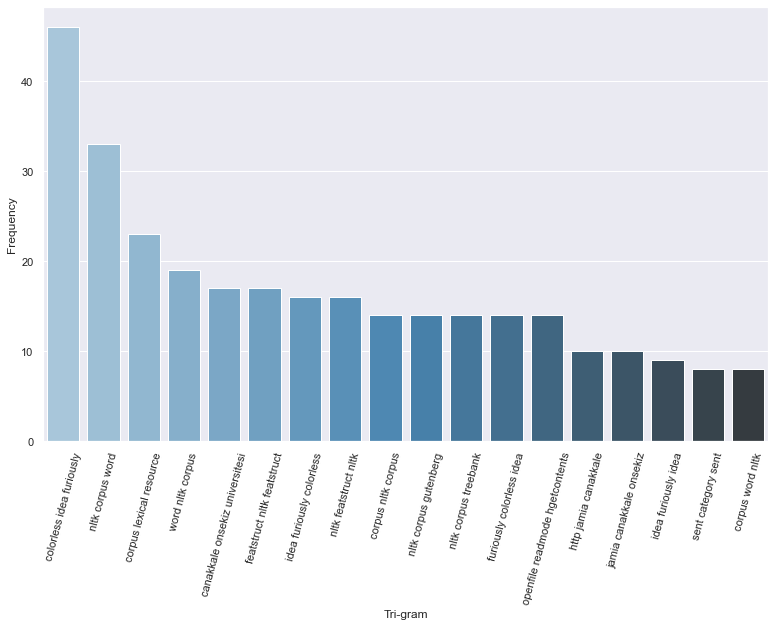

In [57]:
# Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3)).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

# Convert most freq trigrams to dataframe for plotting bar plot, save as CSV
top3_words = get_top_n3_words(corpus, n=18)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Frequency"]
print(top3_df)
top3_df.to_csv(mypath + '\_trigrams.csv')

# Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Frequency", data=top3_df, palette="Blues_d")
j.set_xticklabels(j.get_xticklabels(), rotation=75)
j.figure.savefig(mypath + "\_tri-gram.png", bbox_inches = "tight")

## Test için ayırdığımız dosyalarda sonuçları test etme

In [58]:
related_test_pdf_files = [f for f in os.listdir(mypath+'/test_pdf/related')]

In [59]:
related_test_book_text = ""
print("=============START=============")
for pf in related_test_pdf_files:
    if '.pdf' in pf:
        print('===>'+ pf)
        reader = pydf.PdfFileReader(mypath+'/test_pdf/related/'+ pf, strict=False)
        number_of_pages = reader.numPages
        for page in reader.pages:
            related_test_book_text += page.extractText()
print("==============END==============")    

=============START=============
===>eisenstein-nov18.pdf
===>NLP.web.pdf
==============END==============


In [60]:
nonrelated_test_pdf_files = [f for f in os.listdir(mypath+'/test_pdf/nonrelated')]

In [61]:
nonrelated_test_book_text = ""
print("=============START=============")
for pf in nonrelated_test_pdf_files:
    if '.pdf' in pf:
        print('===>'+ pf)
        reader = pydf.PdfFileReader(mypath+'/test_pdf/nonrelated/'+ pf, strict=False)
        number_of_pages = reader.numPages
        for page in reader.pages:
            nonrelated_test_book_text += page.extractText()
print("==============END==============")  

=============START=============
===>Quantum Computing_ Progress and Prospects - Emily Grumbling.pdf
===>Space, Time and Einstein ( PDFDrive ).pdf
==============END==============


Bulunan kelimeleri cümle içinde görmek için elde ettiğimiz text'i tarama işlemi

In [62]:
for i in top_words:
     for j in pdf_sentence_text:
            if(len(j)<50 and len(j)>len(i[0])*3):
                t=clean(j, set())
                if i[0] in t:
                    print(i[0]+' : '+t)

word : wordnet lexical database english
word : glove global vector word representation
word : word structure
word : wordnet
word : simple example word list
word : match pair word like
word : comparing word length different language
word : categorizing tagging word
word : typed word
word : eyword sear ching word
word : howmany word
word : playing with word
word : from word sentence
word : word list
word : word frequency list
word : word pattern matching
word : other type word have inflection well
word : line word
word : other word addition conditional
word : silly were fooled word list
word : what actually want build word
word : word value never escape monad
word : move window word right
word : move window word right
word : other word bias
word : both sentence contain word trust
nltk : activity using nltk tool
nltk : tokenisation nltk
nltk : using nltk tool page
nltk : nltk index
nltk : nltk
corpus : corpus annotation scheme
corpus : corpus other data resource
corpus : some us corpus
co

In [63]:
for i in top2_words:
    for j in pdf_sentence_text:
        if(len(j)<50 and len(j)>len(i[0])*3):
            t=clean(j, set())
            if i[0] in t:
                print(i[0]+' : '+t)

corpus lexical : accessing text corpus lexical resource


In [64]:
for i in top3_words:
    for j in pdf_sentence_text:
        if(len(j)<50 and len(j)>len(i[0])*3):
            t=clean(j, set())
            if i[0] in t:
                print(i[0]+' : '+t)

#### Bulduğumuz istediğimiz alana özgü kelimelerin ne kadar alana özgü olduğunu test etme
Öncelikle bulduğumuz kelimeleri istediğimiz alanda daha önce kullanmadığımız kaynaklarda sıklığını buluyoruz.

In [65]:
counter_text_of_interest=0
c = clean(related_test_book_text, set()).split()
for i in top_words:
     for j in c:
            if i[0] in j:
                counter_text_of_interest+=1
counter_text_of_interest

8750

Sonrasında bulduğumuz kelimeleri alakasız alanlarda daha önce kullanmadığımız kaynaklarda sıklığını buluyoruz.

In [66]:
counter_other_text=0
sbt = clean(nonrelated_test_book_text, set()).split()
for i in top_words:
    for j in sbt:
        if i[0] in j:
            counter_other_text+=1
counter_other_text

3128

In [67]:
print('Bulduğumuz kelimelerin istediğimiz alanda bulunma oranı:',counter_text_of_interest/len(c))
print('Bulduğumuz kelimelerin diğer alanlarda bulunma oranı:',counter_other_text/len(sbt))

Bulduğumuz kelimelerin istediğimiz alanda bulunma oranı: 0.08141731257734644
Bulduğumuz kelimelerin diğer alanlarda bulunma oranı: 0.02674921753407789
